# Initialize data sources

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, Markdown, HTML
import seaborn
import us

# https://healthdata.gov/dataset/covid-19-reported-patient-impact-and-hospital-capacity-state-timeseries
hhs_data = pd.read_csv('https://healthdata.gov/sites/default/files/reported_hospital_utilization_timeseries_20201213_2141.csv', parse_dates=['date']).set_index(['state', 'date']).sort_index()

can_data = pd.read_csv('https://api.covidactnow.org/v2/states.timeseries.csv?apiKey=dd3c11e7428f4663a734092ee4158862', parse_dates=['date']).set_index(['state', 'date']).sort_index()
can_summary = pd.read_csv('https://api.covidactnow.org/v2/states.csv?apiKey=dd3c11e7428f4663a734092ee4158862').set_index(['state']).sort_index()

GREEN='#C4ECAA'
YELLOW='#FFFFC0'
ORANGE='#F7C000'
RED='#FA6261'

# Merge / massage data sources into a cleaner data set.

In [2]:
# Merge the timeseries (hhs_data and can_data) first so we get the full set of dates in the index.
hhs_can_merged=hhs_data.join(can_data, how='outer', rsuffix='_can')

In [3]:
# Add CAN summary data.
hhs_can_summary_merged=hhs_can_merged.join(can_summary, on='state', rsuffix='_summary')
data=hhs_can_summary_merged

In [5]:
data = hhs_can_summary_merged

# Helper funcs to get latest values and plot worst states.

In [6]:
def worst_states(column, count=10):
    current_data=data.groupby('state').last()
    return current_data.nlargest(count, column).index.tolist()

def plot_worst_states(column, title, count=10, start_date=None, **plot_args):
    worst_states_list = worst_states(column, count)
    display('Worst States:', worst_states_list)
    worst_states_data = data[data.index.get_level_values('state').isin(worst_states_list)]

    d = worst_states_data[column].reset_index('state').pivot(columns='state', values=column)
    if start_date != None:
        d = d[d.index > pd.to_datetime(start_date)]

    d.plot(figsize=(12, 8), linewidth=3, title=title, grid=True, **plot_args)

# ICU Headroom using HHS data (should match website).

In [198]:
# TODO: Include suspected, or no?
#covid_icu_patients_column='staffed_icu_adult_patients_confirmed_and_suspected_covid';
covid_icu_patients_column='staffed_icu_adult_patients_confirmed_covid';
data['hhs_icu_noncovid'] = data['staffed_adult_icu_bed_occupancy'] - data[covid_icu_patients_column];
data['hhs_icu_headroom'] = data['total_staffed_adult_icu_beds'] - data['hhs_icu_noncovid'];
data['hhs_icu_headroom_used'] = (data[covid_icu_patients_column] / data['hhs_icu_headroom']).rolling(7).mean()

# HHS ICU Beds Utilization %

In [197]:
data['adult_icu_bed_utilization_avg'] = data['adult_icu_bed_utilization'].rolling(7).mean()

# HHS Inpatient Beds Utilization %

In [196]:
data['inpatient_beds_utilization_avg'] = data['inpatient_beds_utilization'].rolling(7).mean()

# COVID Hospitalizations per 100k (HHS)

In [195]:
data['inpatient_beds_used_confirmed_covid'] = data['total_adult_patients_hospitalized_confirmed_and_suspected_covid']+data['total_pediatric_patients_hospitalized_confirmed_and_suspected_covid']
data['inpatient_beds_used_confirmed_covid_per_100k'] = (data['inpatient_beds_used_confirmed_covid'] / (data['population'] / 100000)).rolling(7).mean()

# COVID ICU Utilization %

In [194]:
data['covid_icu_utilization_%'] = (data['staffed_icu_adult_patients_confirmed_covid'] / data['total_staffed_adult_icu_beds']).rolling(7).mean()

# COVID ICU Patients %

In [193]:
data['covid_icu_patients_%'] = (data['staffed_icu_adult_patients_confirmed_covid'] / data['staffed_adult_icu_bed_occupancy']).rolling(7).mean()

# Calculate % Critical Staffing shortage (via HHS data)

In [11]:
# Calculate critical_shortage_%
critical_shortage_pct=data['critical_staffing_shortage_today_yes']/(data['critical_staffing_shortage_today_yes']+data['critical_staffing_shortage_today_no'])
critical_shortage_pct=critical_shortage_pct.reset_index('state').groupby('state').rolling(7).mean().reset_index().set_index(['state', 'date'])
data['critical_staffing_shortage_%'] = critical_shortage_pct

# Covid Admissions per 100 beds.

In [34]:
data['weekly_confirmed_covid_admissions'] = (data['previous_day_admission_adult_covid_confirmed']).rolling(7).sum()
data['100_beds_7_day_avg'] = data['inpatient_beds'].rolling(7).mean()/100
data['confirmed_covid_admissions_per_100_beds'] = data['weekly_confirmed_covid_admissions']/(data['100_beds_7_day_avg'])

# Metric Chart Helpers

In [137]:
CHART_START_DATE = '2020-09-01'

In [199]:
def covid_admissions_per_100_beds_chart(state, ax=None):
    if not ax:
        fig, ax = plt.subplots()
    data.loc[state]['confirmed_covid_admissions_per_100_beds'].plot(title='Wk CVD Adm / 100 beds[WH]', ax=ax, lw=2, xlim=(CHART_START_DATE,None), ylim=(0, 30))

    ax.axhspan(ymin=0, ymax=5, color=GREEN)
    ax.axhspan(ymin=5, ymax=10, color=YELLOW)
    ax.axhspan(ymin=10, ymax=20, color=ORANGE)
    ax.axhspan(ymin=20, ymax=30, color=RED)
    return ax

# covid_admissions_per_100_beds_chart('ND')

In [200]:
def hhs_icu_headroom_chart(state, ax=None):
    if not ax:
        fig, ax = plt.subplots()
    (data.loc[state]['hhs_icu_headroom_used'] * 100).plot(title='ICU Headroom Used %[CAN]', ax=ax, lw=2, ylim=(0, 100), xlim=(CHART_START_DATE,None))

    ax.grid(axis='x')
    ax.axhspan(ymin=0, ymax=50, color=GREEN)
    ax.axhspan(ymin=50, ymax=60, color=YELLOW)
    ax.axhspan(ymin=60, ymax=70, color=ORANGE)
    ax.axhspan(ymin=70, ymax=100, color=RED)

# hhs_icu_headroom_chart('ND')

In [201]:
def ces_icu_utilization_chart(state, ax=None):
    if not ax:
        fig, ax = plt.subplots()
    (data.loc[state]['adult_icu_bed_utilization']*100).rolling(7).mean().plot(title='ICU Utilization %[CES]', ax=ax, lw=2, ylim=(0, 100), xlim=(CHART_START_DATE,None))

    ax.grid(axis='x')
    ax.axhspan(ymin=0, ymax=70, color=GREEN)
    ax.axhspan(ymin=70, ymax=80, color=YELLOW)
    ax.axhspan(ymin=80, ymax=85, color=ORANGE)
    ax.axhspan(ymin=85, ymax=100, color=RED)

# ces_icu_utilization_chart('ND')

In [202]:
def ces_bed_utilization_chart(state, ax=None):
    if not ax:
        fig, ax = plt.subplots()
    (data.loc[state]['inpatient_beds_utilization']*100).rolling(7).mean().plot(title='Inpatient Utilization %[CES]', ax=ax, lw=2, ylim=(0, 100), xlim=(CHART_START_DATE,None))

    ax.grid(axis='x')
    ax.axhspan(ymin=0, ymax=70, color=GREEN)
    ax.axhspan(ymin=70, ymax=80, color=YELLOW)
    ax.axhspan(ymin=80, ymax=85, color=ORANGE)
    ax.axhspan(ymin=85, ymax=100, color=RED)

# ces_bed_utilization_chart('ND')

In [203]:
data['covid_hospitalizations_per_100k'] = data['total_adult_patients_hospitalized_confirmed_and_suspected_covid'].rolling(7).mean() / (data['population']/100000)

def covid_hospitalizations_per_100k_chart(state, ax=None):
    if not ax:
        fig, ax = plt.subplots()
    data.loc[state]['inpatient_beds_used_confirmed_covid_per_100k'].rolling(7).mean().plot(title='COVID Inpatients per 100k', ax=ax, lw=2, xlim=(CHART_START_DATE,None))

    ax.grid(axis='x')
#    ax.axhspan(ymin=0, ymax=3, color=GREEN)
#    ax.axhspan(ymin=3, ymax=10, color=YELLOW)
#    ax.axhspan(ymin=10, ymax=25, color=ORANGE)
#    ax.axhspan(ymin=25, ymax=70, color=RED)

# covid_hospitalizations_per_100k_chart('ND')

In [204]:
def covid_icu_utilization_chart(state, ax=None):
    if not ax:
        fig, ax = plt.subplots()
    (data.loc[state]['covid_icu_utilization_%']*100).plot(title='ICU COVID Utilization %', ax=ax, lw=2, xlim=(CHART_START_DATE,None), ylim=(0, 60))

    ax.grid(axis='x')
#    ax.axhspan(ymin=0, ymax=10, color=GREEN)
#    ax.axhspan(ymin=10, ymax=20, color=YELLOW)
#    ax.axhspan(ymin=20, ymax=30, color=ORANGE)
#    ax.axhspan(ymin=30, ymax=60, color=RED)

# covid_icu_utilization_chart('NM')

In [205]:
def covid_icu_patients_chart(state, ax=None):
    if not ax:
        fig, ax = plt.subplots()
    (data.loc[state]['covid_icu_patients_%']*100).plot(title='% ICU Patients w/ COVID', ax=ax, lw=2, xlim=(CHART_START_DATE,None), ylim=(0, 60))

    ax.grid(axis='x')
#    ax.axhspan(ymin=0, ymax=10, color=GREEN)
#    ax.axhspan(ymin=10, ymax=20, color=YELLOW)
#    ax.axhspan(ymin=20, ymax=30, color=ORANGE)
#    ax.axhspan(ymin=30, ymax=60, color=RED)

# covid_icu_patients_chart('NM')

In [206]:
def show_state_charts(state):
    display(HTML('<h2>' + us.states.lookup(state).name + '</h2>'))
    fig, axes = plt.subplots(nrows=1, ncols=7, figsize=(24,3))
    hhs_icu_headroom_chart(state, axes[0])
    ces_icu_utilization_chart(state, axes[1])
    covid_icu_utilization_chart(state, axes[2])
    covid_icu_patients_chart(state, axes[3])
    covid_admissions_per_100_beds_chart(state, axes[4])
    covid_hospitalizations_per_100k_chart(state, axes[5])
    ces_bed_utilization_chart(state, axes[6])
    display(fig)
    plt.close()
    
#show_state_charts('AR')

# Metric Charts for all States

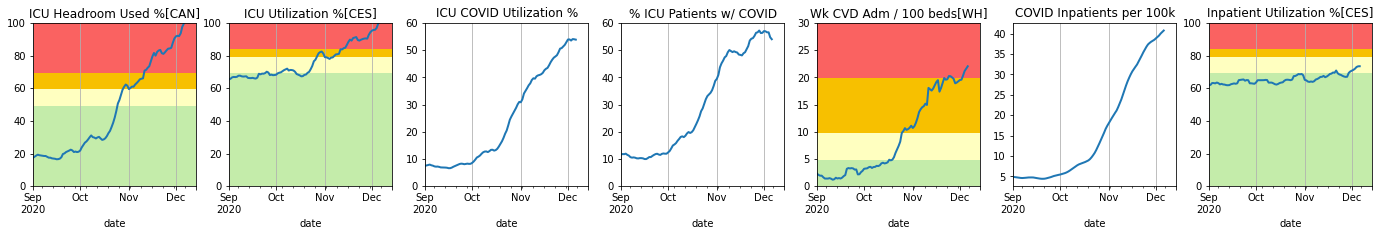

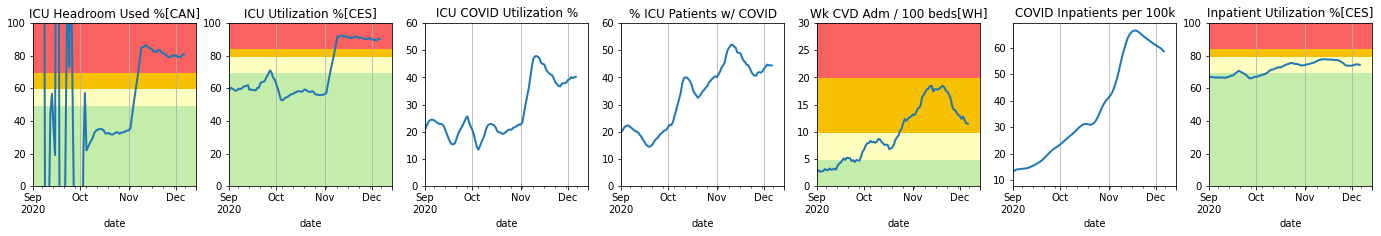

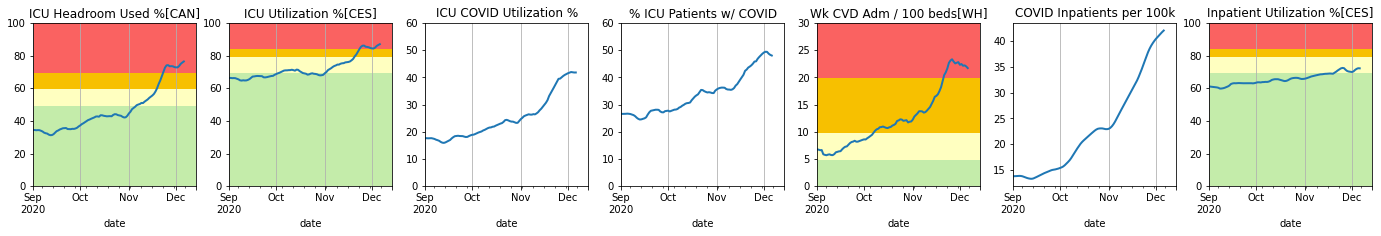

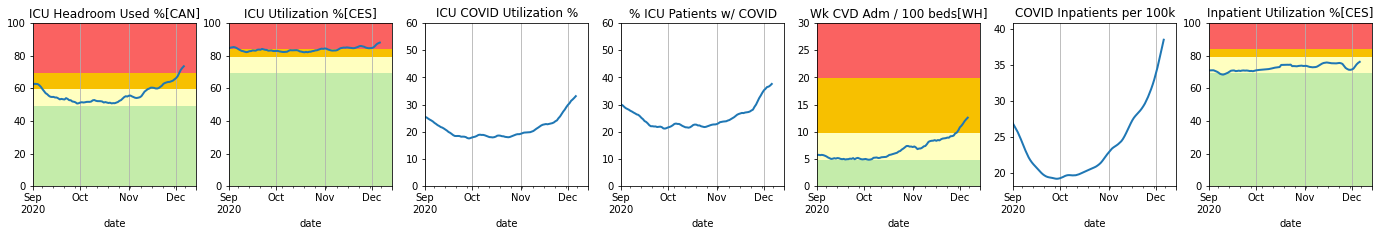

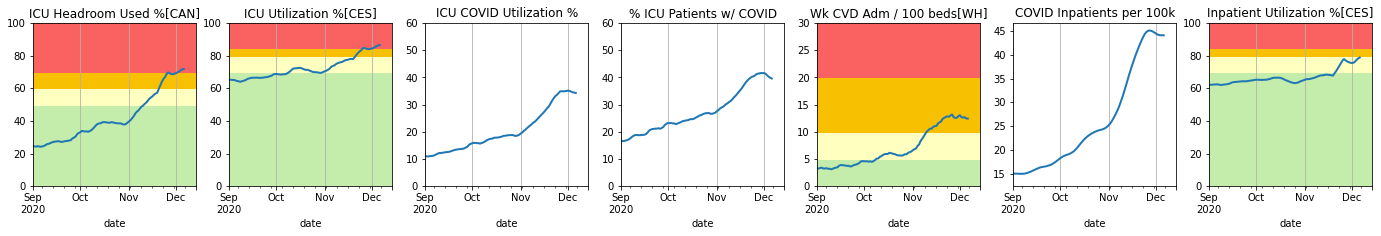

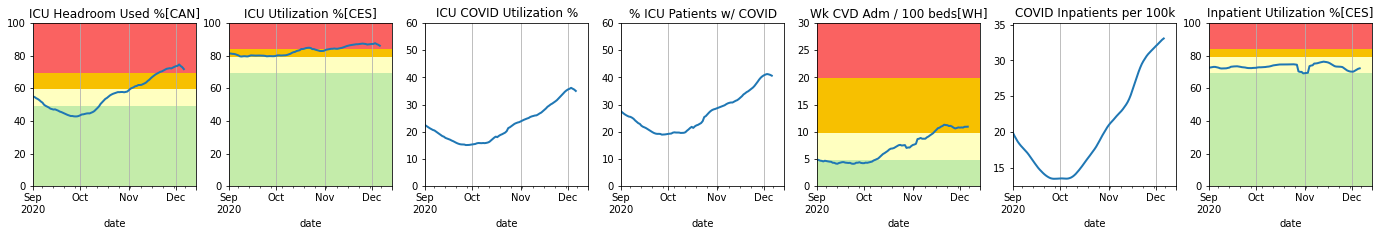

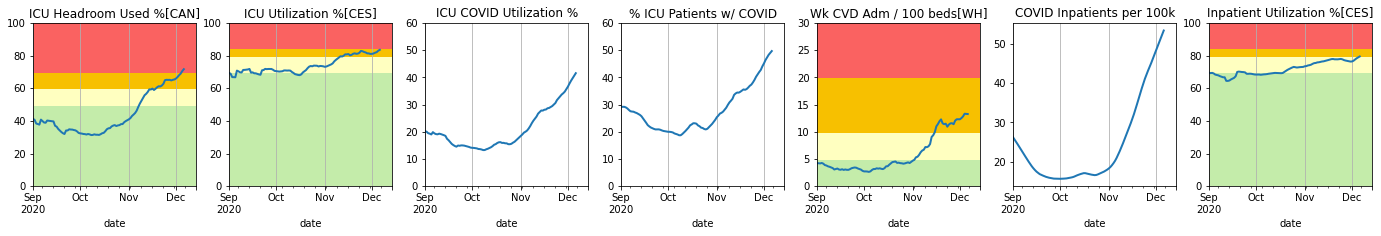

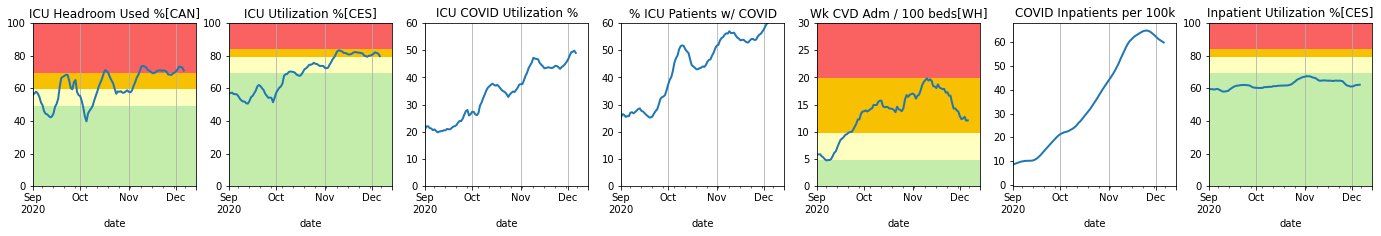

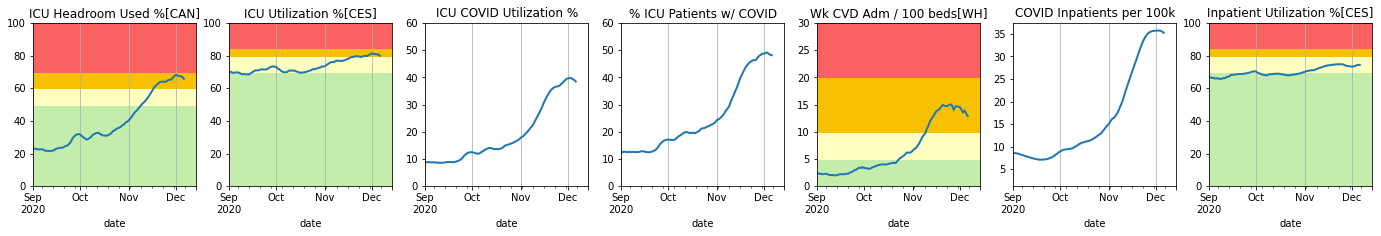

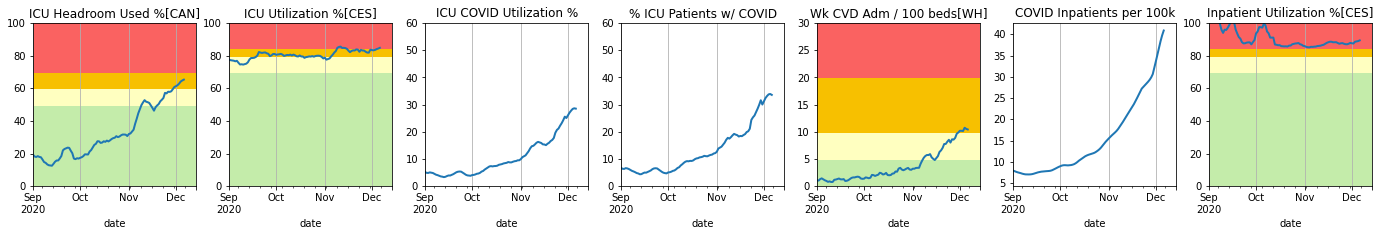

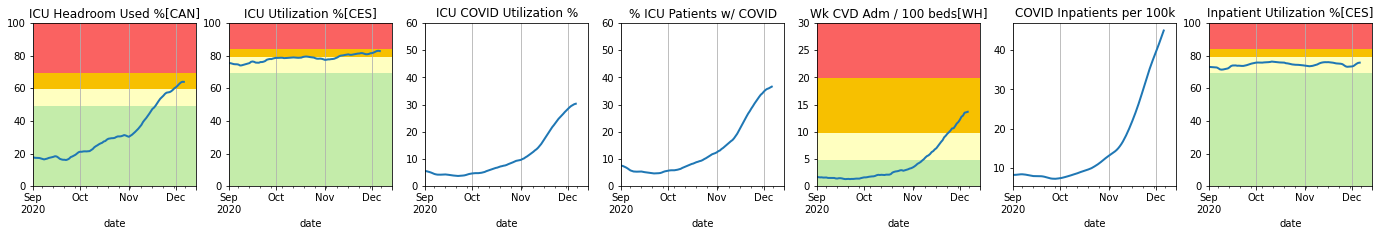

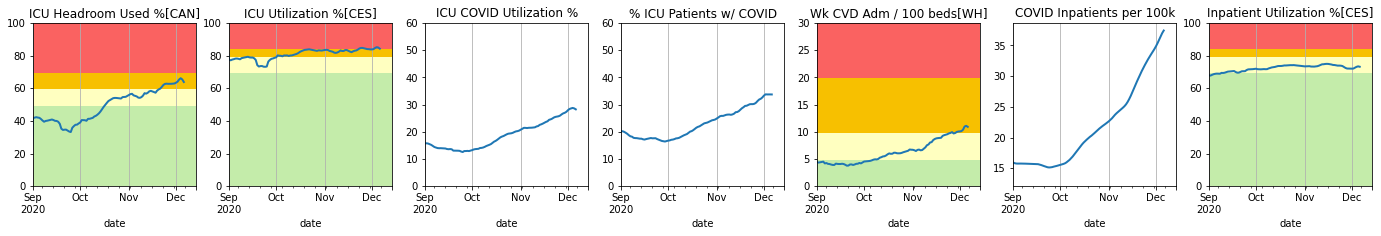

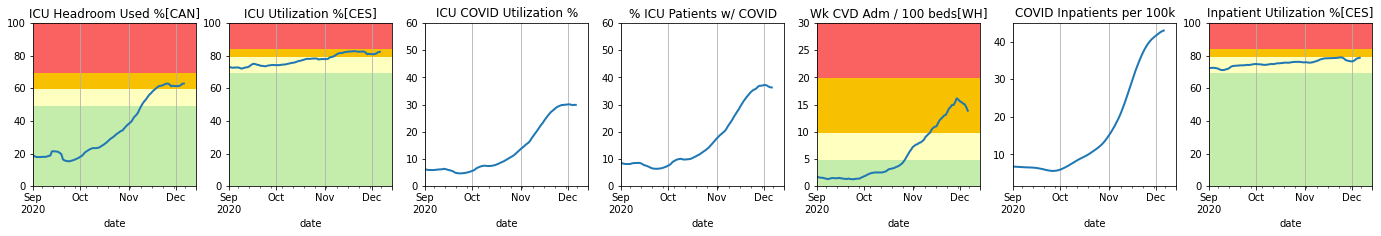

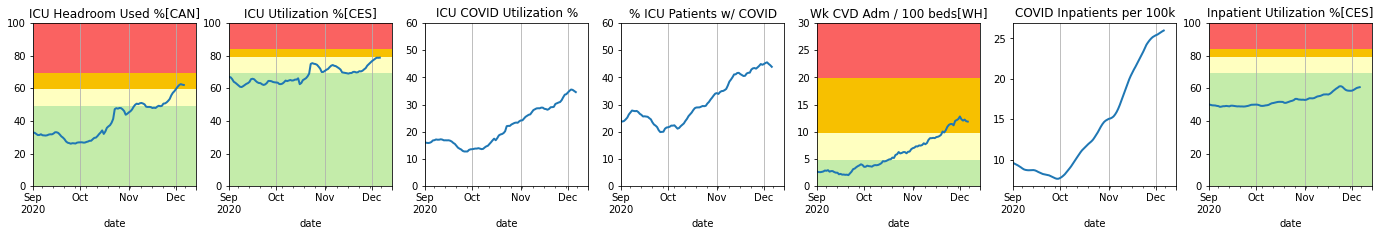

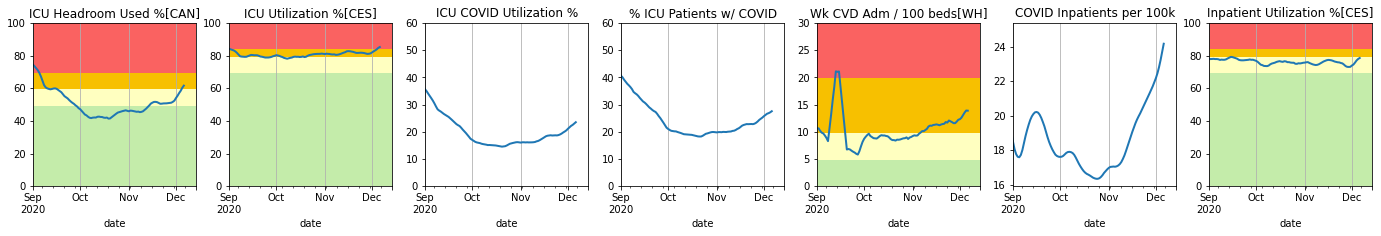

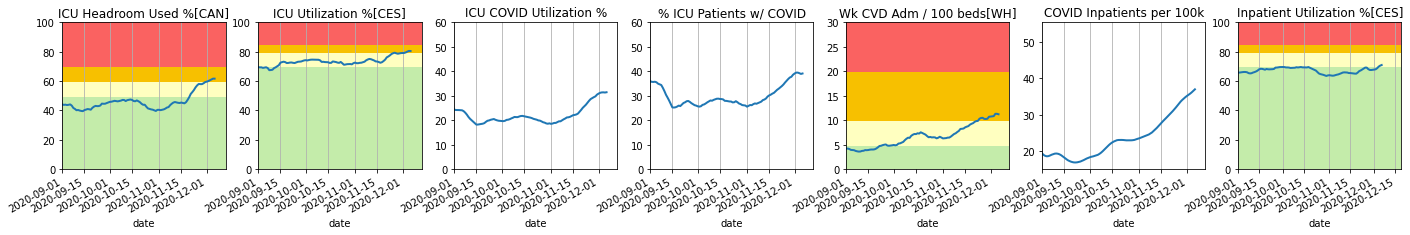

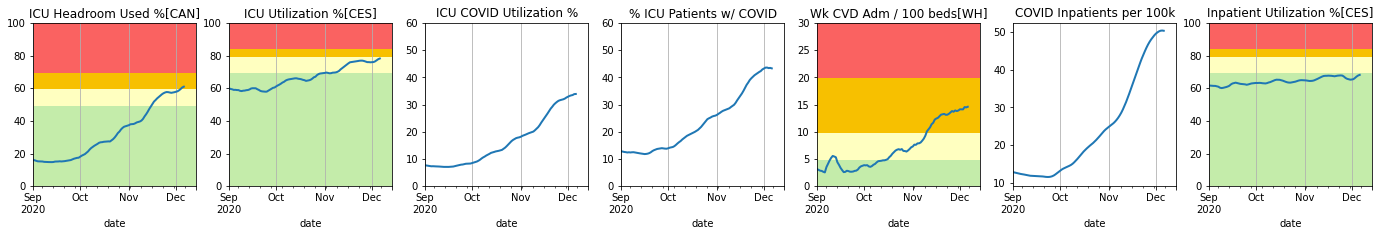

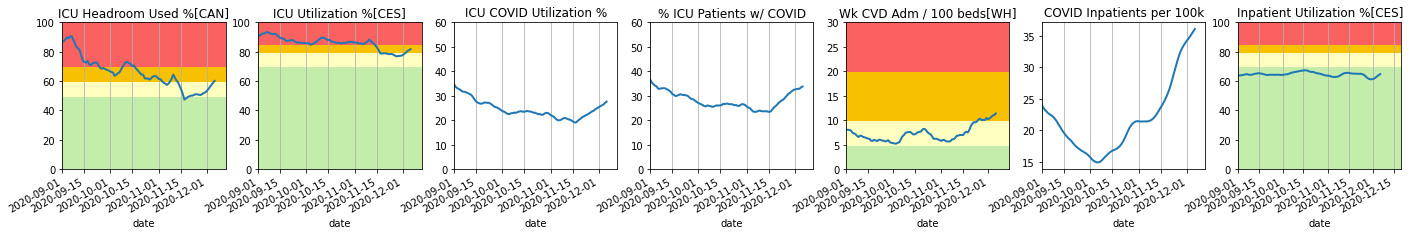

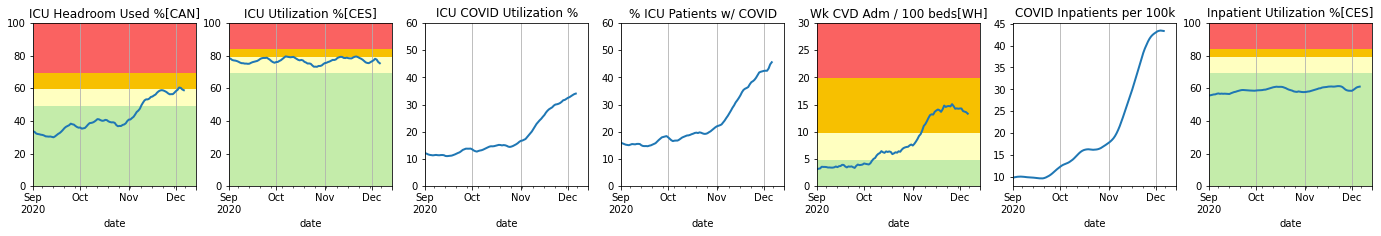

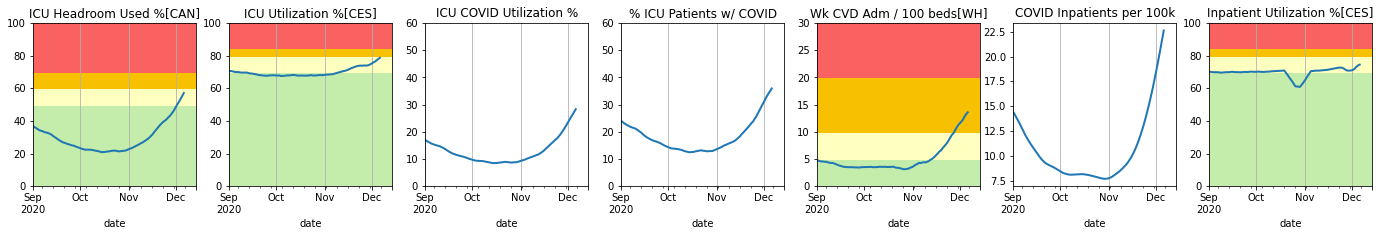

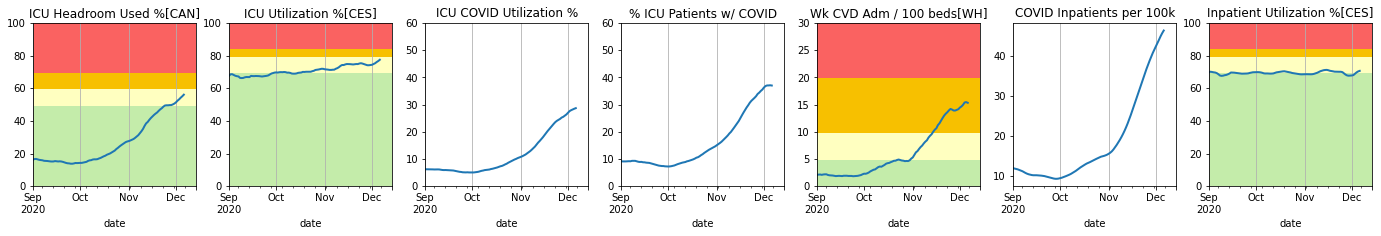

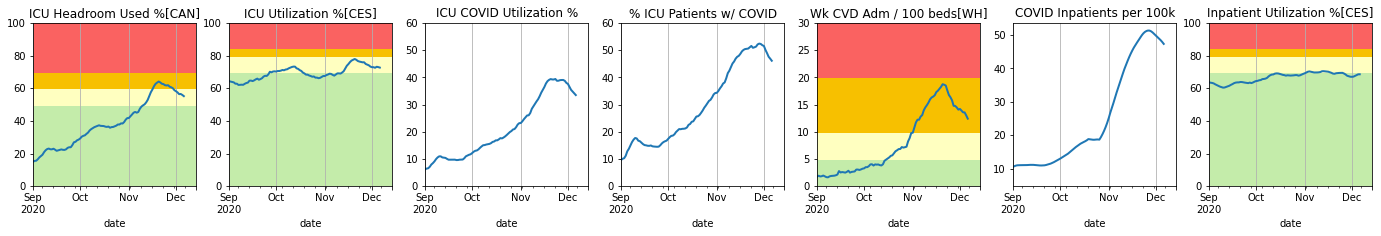

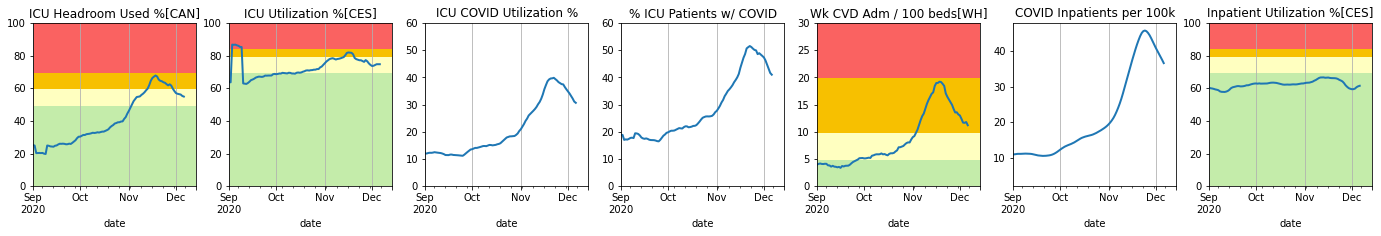

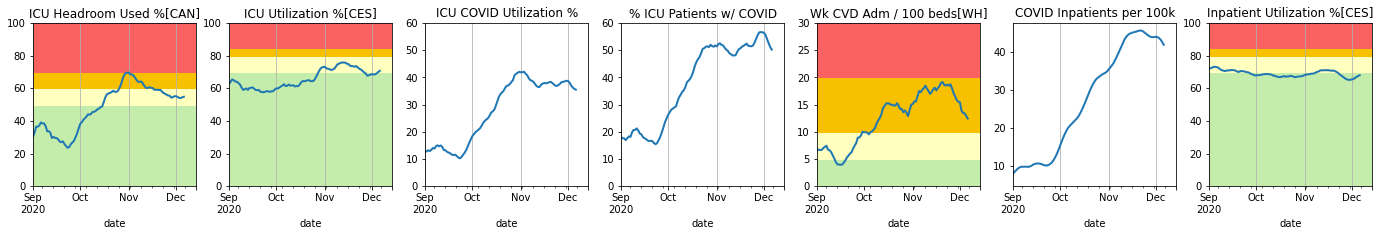

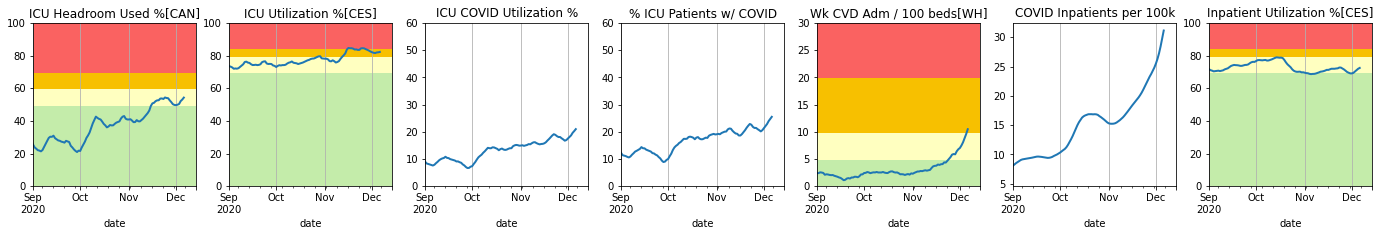

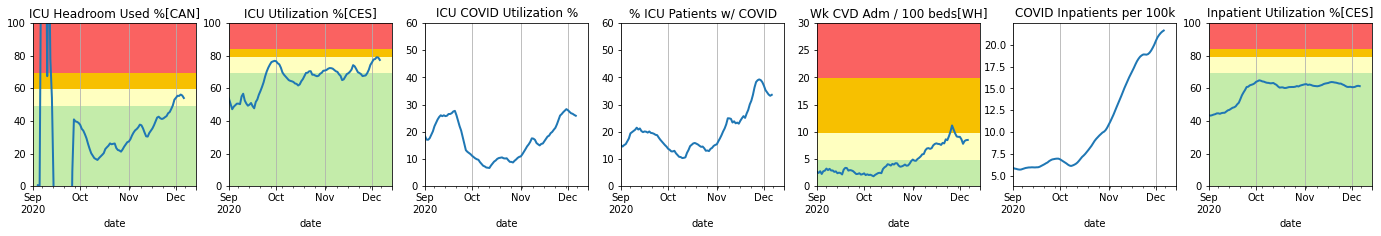

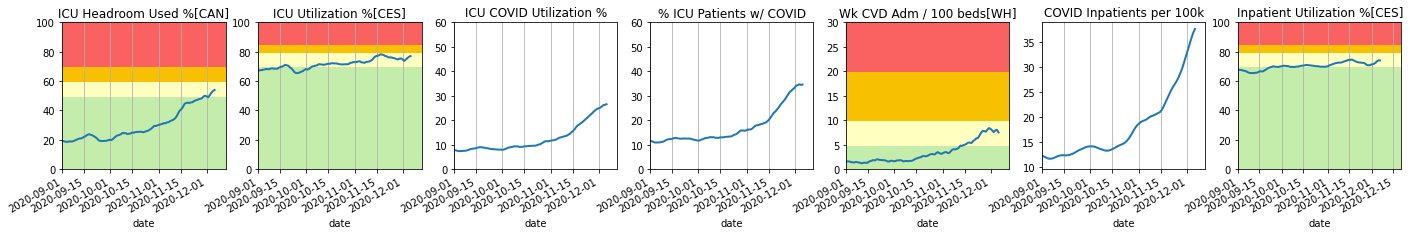

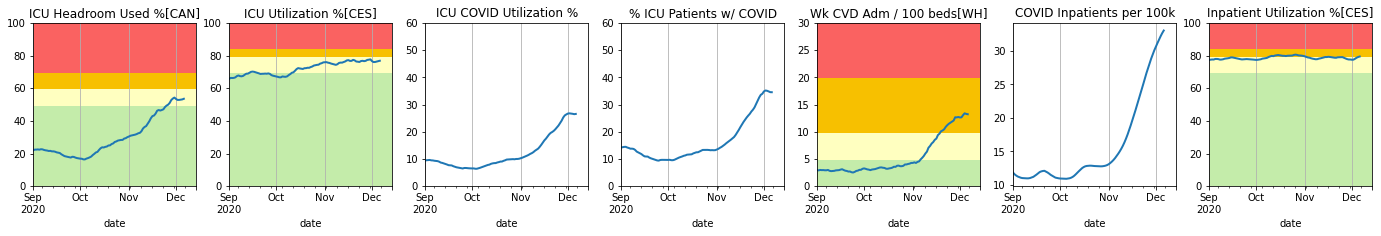

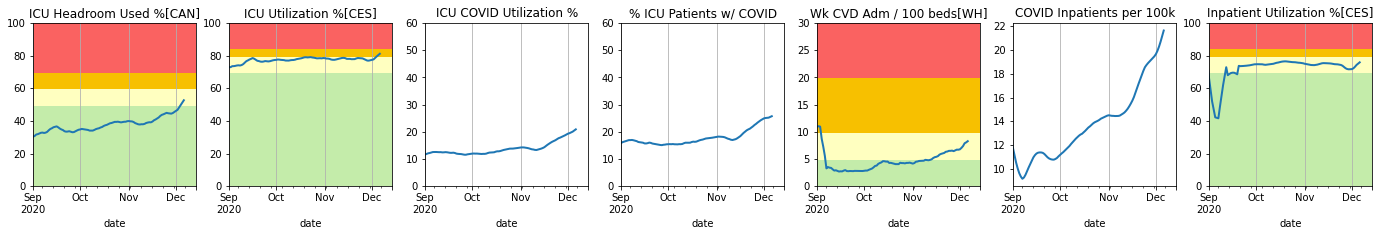

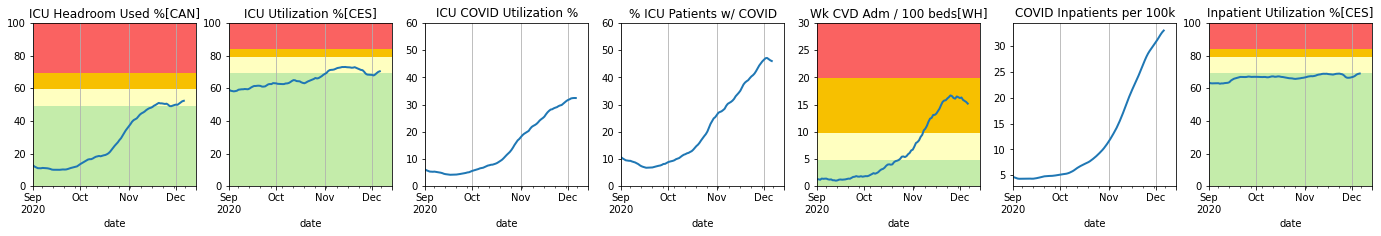

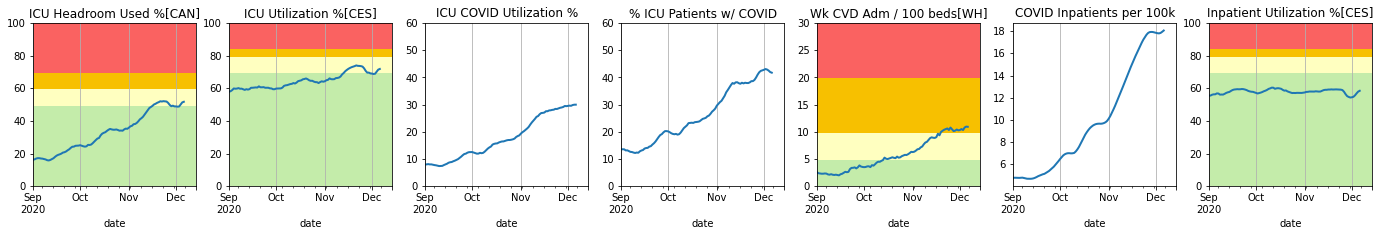

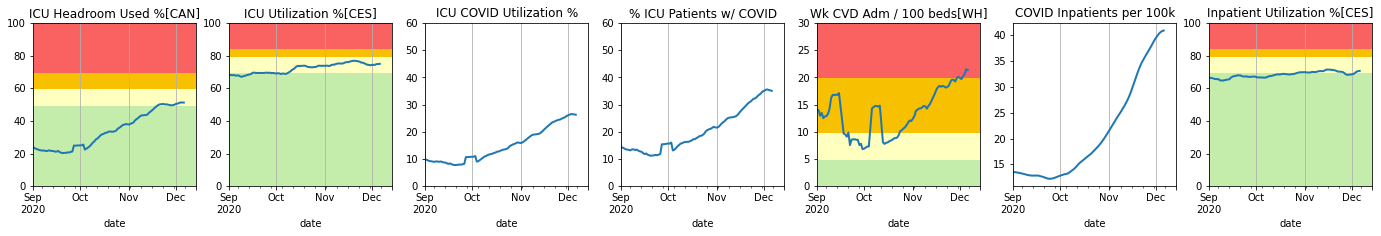

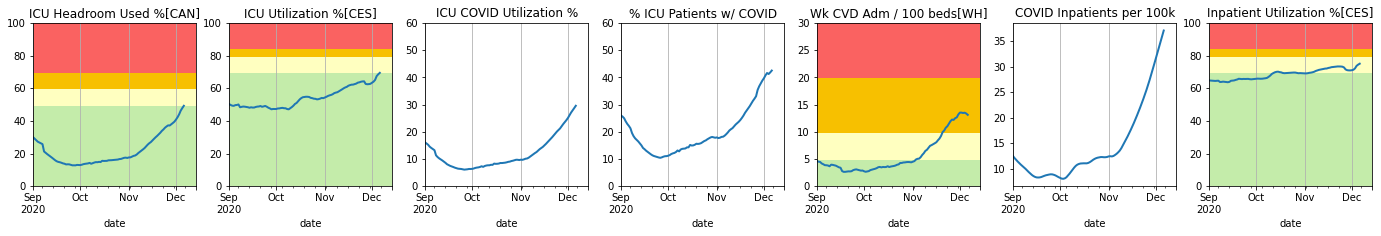

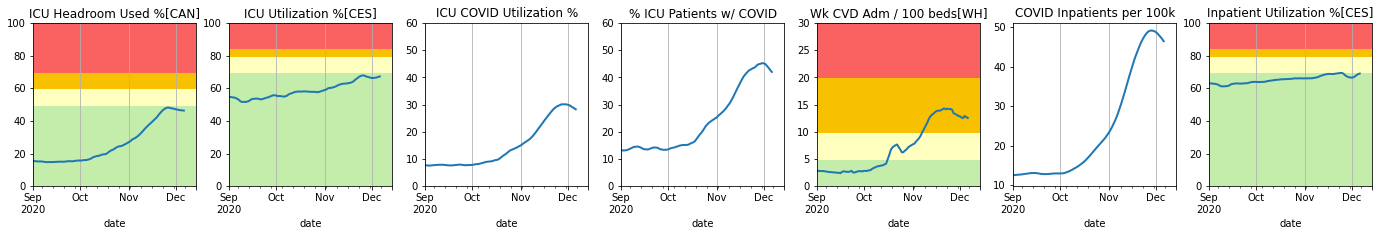

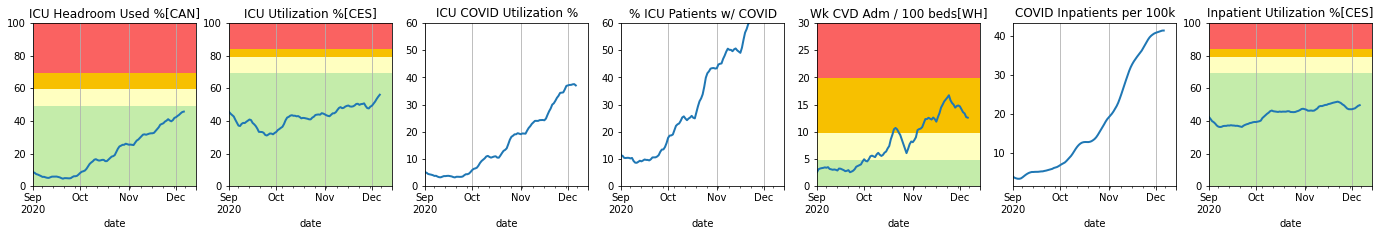

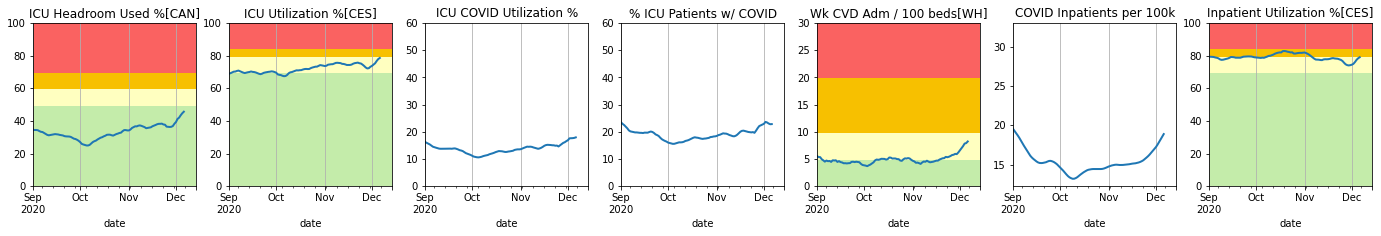

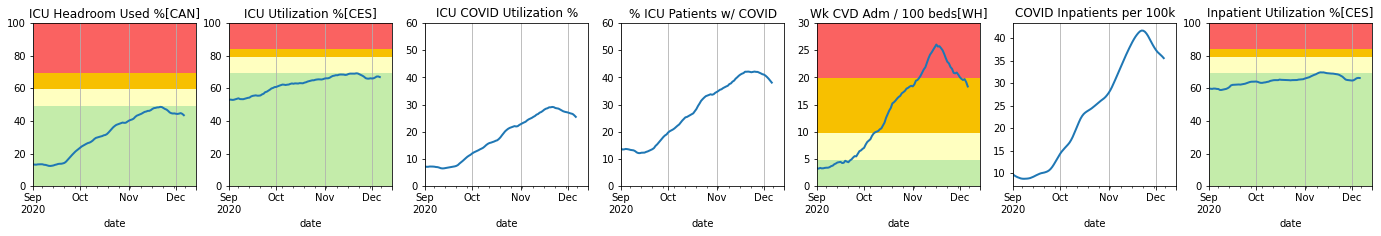

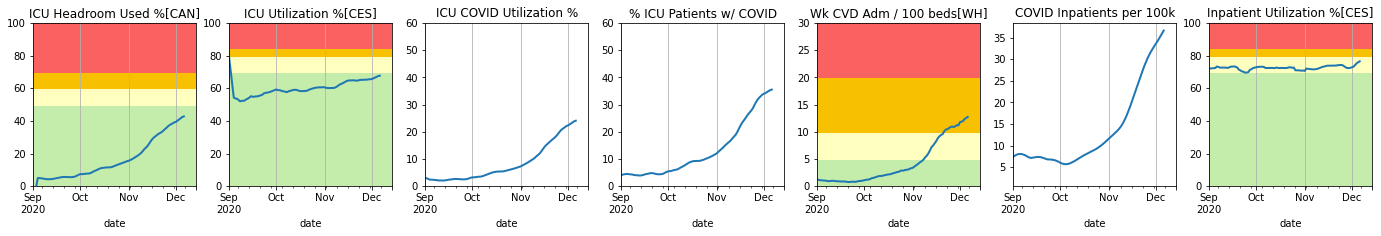

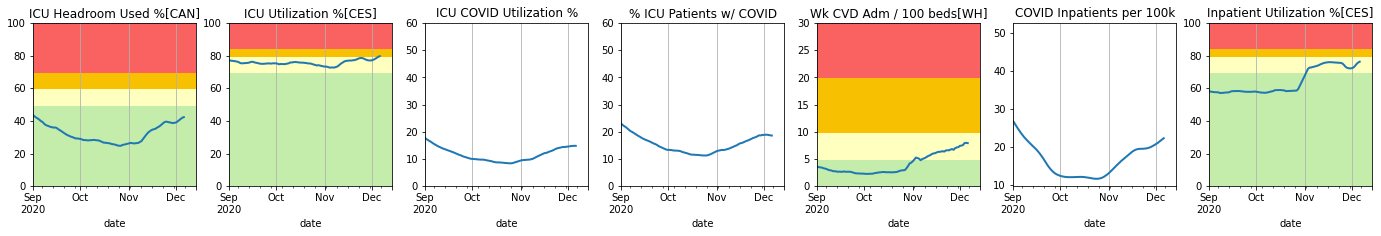

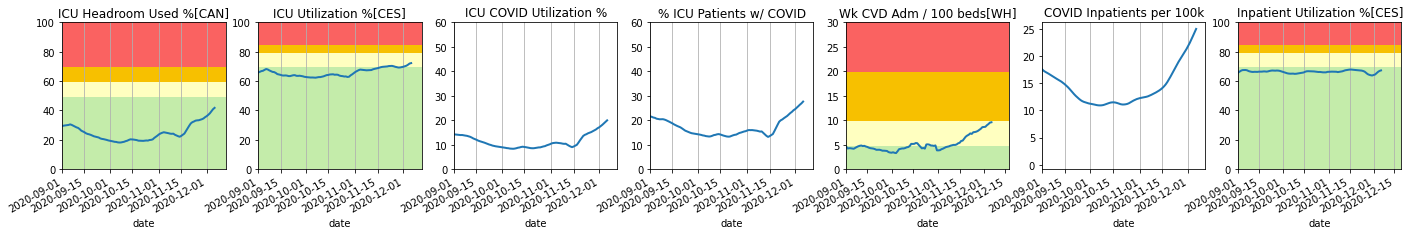

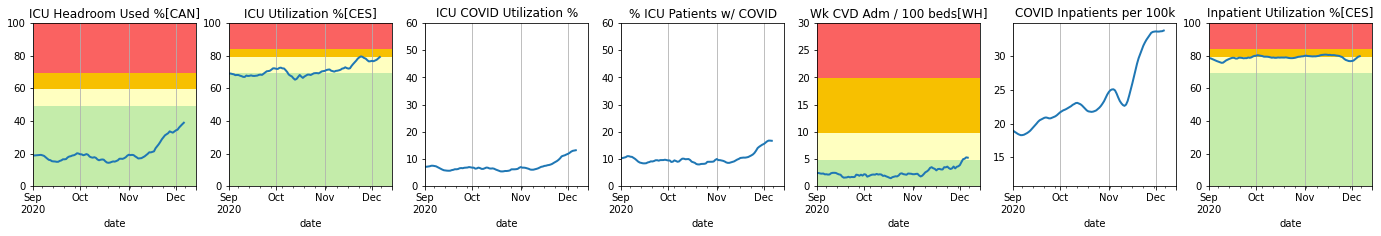

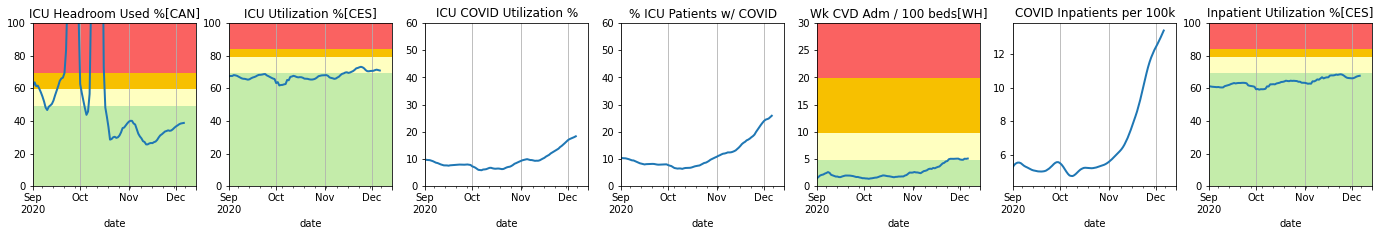

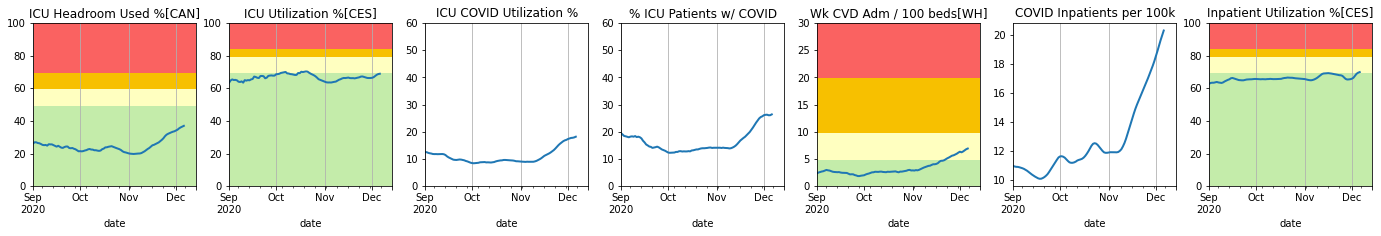

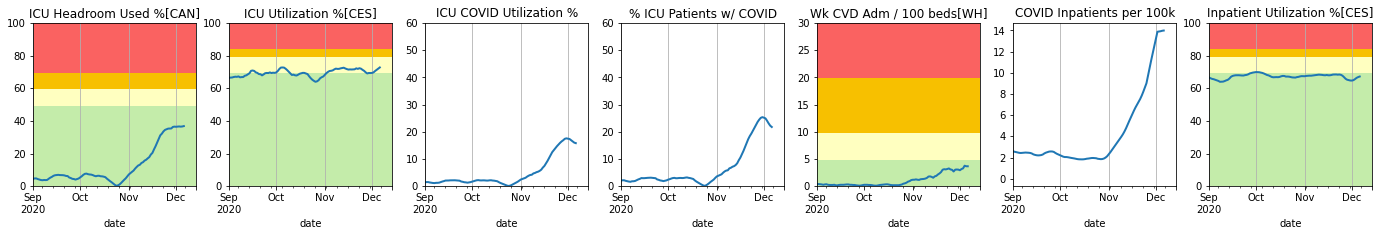

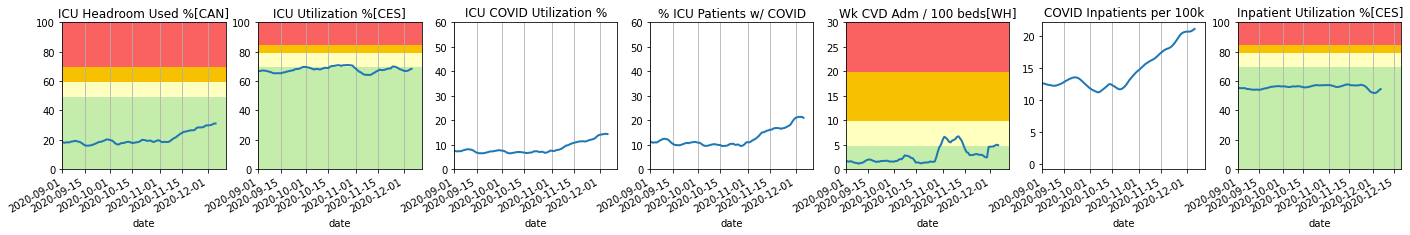

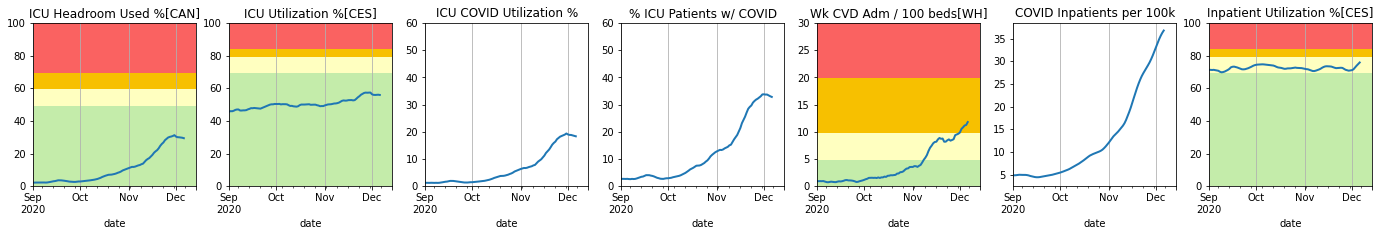

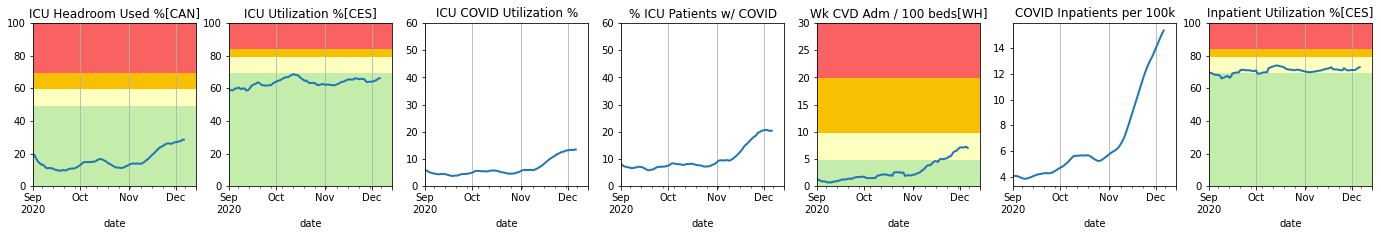

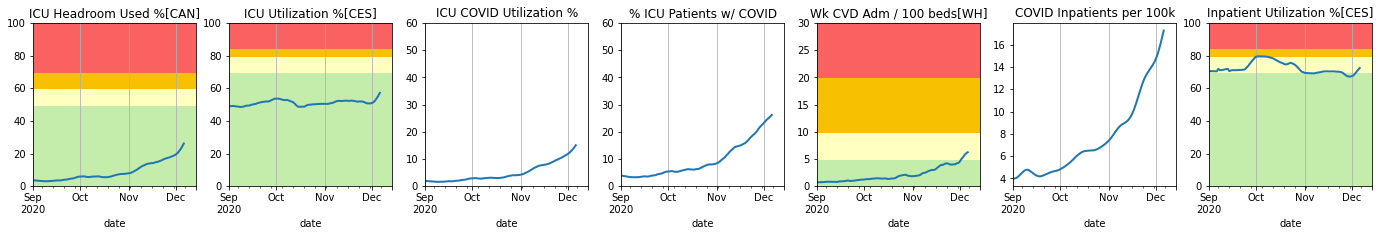

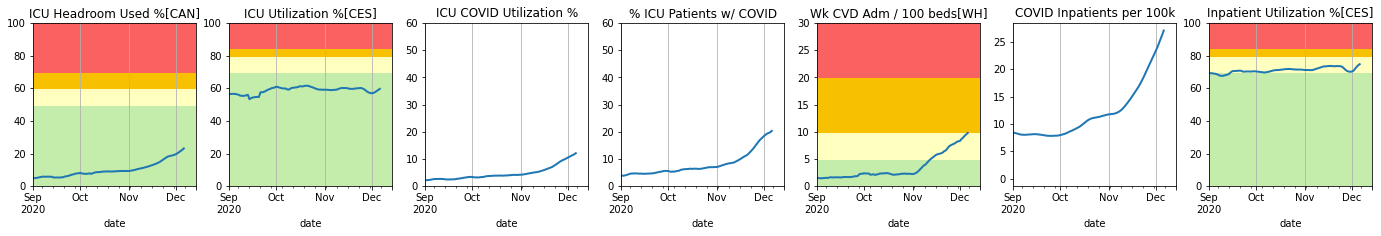

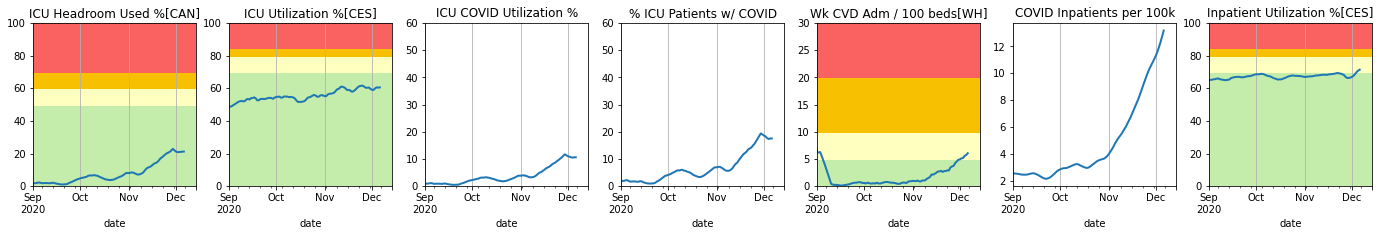

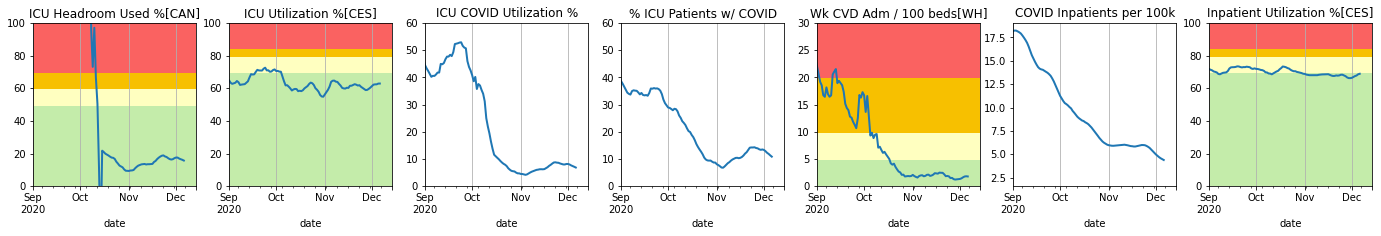

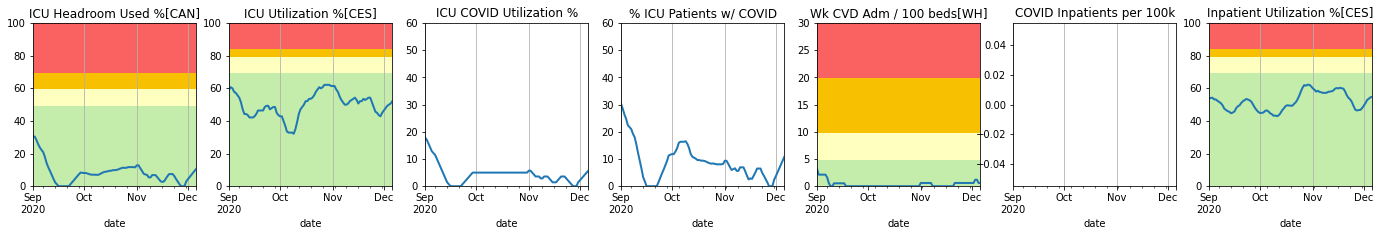

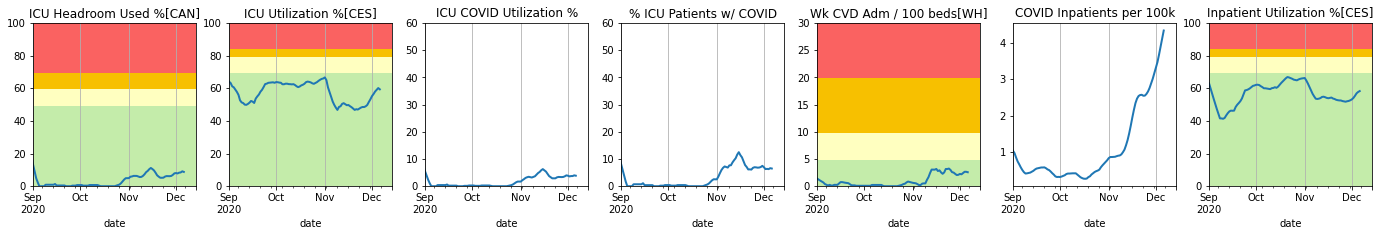

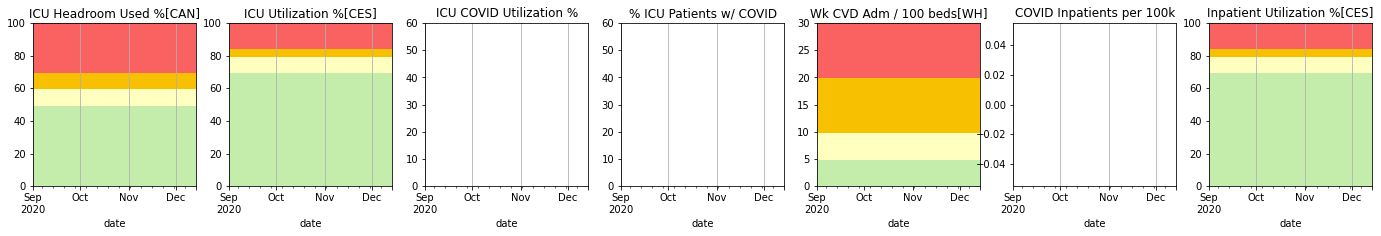

In [192]:
states_by_worst = data.groupby('state').last()['hhs_icu_headroom_used'].sort_values(ascending=False).index.to_list()
for state in states_by_worst:
    show_state_charts(state)